# Neural Networks

In this notebook we will use [Neural Networks](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier) to perform the classification task.  

In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import warnings

warnings.filterwarnings('ignore')

df_AIMD = pd.read_csv("Dist_AIMD.csv") 
df_MD = pd.read_csv('Dist_MD.csv')
df_fin = pd.concat([df_AIMD, df_MD])

df_shuffle = shuffle(df_fin, random_state=0)

from sklearn.model_selection import train_test_split

# Data selection 
# First we shall select the closest oxygens and later add the rest to see the effects of increasing features
# Then we will repeat it for hydrogens
X3 = df_shuffle[['S-O1', 'C-O1', 'N-O1']]
X6 = df_shuffle[['S-O1', 'C-O1', 'N-O1', 'S-O2', 'C-O2', 'N-O2']]

H3 = df_shuffle[['S-H1', 'C-H1', 'N-H1']]
H6 = df_shuffle[['S-H1', 'C-H1', 'N-H1', 'S-H2', 'C-H2', 'N-H2']]
y = df_shuffle['Class']

# Splitting the data into training(80%) and test(20%) set

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y, test_size=0.20, random_state=0)
X6_train, X6_test, y6_train, y6_test = train_test_split(X6, y, test_size=0.20, random_state=0)

## Neural Networks: Single layer vs multi layer

Multilayer perceptrons with a single hidden layer is what we are referring to 'Single layer networks'. Adding more hidden layers increases the complexity of the learning task but in our case we will use 1 and 2 hidden layers to see the differences. 

The following are several important parameters, 
1. hidden_layer_sizes: Size of the hidden layers. [10] means one hidden layers with 10 neurons, [10,10] means 2 hidden layers with 10 neurons each. 
2. solver: Algorithm used for optimization of weights. Can be 
-'adam': 
-'lbfgs'
-'sgd'
3. alpha: Strength of the L2 regularization term
4. activation: Activation function to be used, can be
- ‘identity’
- ‘logistic’
- ‘tanh’
- ‘relu’

There are several other parameters that depend on which solver we select, e.g., learning_rate is only used for sgd solver. 

## Single hidden layer network

In [2]:
from sklearn.neural_network import MLPClassifier

#Default classifier
nn_clf = MLPClassifier(random_state=0)

# 3 feature model
nn_clf.fit(X3_train, y3_train)

print("Number of features: ", nn_clf.n_features_in_)
print("Number of layers: ", nn_clf.n_layers_)
print("Parameters for the NN: ", nn_clf.get_params(deep=True))
print("Training accuracy for default single hidden layer NN with 3 features: ", nn_clf.score(X3_train, y3_train))
print("Test accuracy for default single hidden layer NN with 3 features: ", nn_clf.score(X3_test, y3_test))

# 6 feature model
nn_clf.fit(X6_train, y6_train)

print("\nNumber of features: ", nn_clf.n_features_in_)
print("Number of layers: ", nn_clf.n_layers_)
print("Training accuracy for default single hidden layer NN with 6 features: ", nn_clf.score(X6_train, y6_train))
print("Test accuracy for default single hidden layer NN with 6 features: ", nn_clf.score(X6_test, y6_test))

Number of features:  3
Number of layers:  3
Parameters for the NN:  {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 0, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
Training accuracy for default single hidden layer NN with 3 features:  0.7297297297297297
Test accuracy for default single hidden layer NN with 3 features:  0.7261904761904762

Number of features:  6
Number of layers:  3
Training accuracy for default single hidden layer NN with 6 features:  0.7627627627627628
Test accuracy for default single hidden layer NN with 6 features:  0.75


### The performance is not good which is expected since we did not choose suitable parameters.

Since there are a lot of parameters let's start small. 

Our classification task is binary, so a ReLu activation function may not be suitable, the logistic sigmoid function might be a better choice. Let's see what effect only changing the activation function is, 

In [3]:
# Only change the activation function
nn_clf = MLPClassifier(random_state=0, activation='logistic')

# 6 feature model
nn_clf.fit(X6_train, y6_train)

print("\nNumber of features: ", nn_clf.n_features_in_)
print("Number of layers: ", nn_clf.n_layers_)
print("Training accuracy for default single hidden layer NN with 6 features: ", nn_clf.score(X6_train, y6_train))
print("Test accuracy for default single hidden layer NN with 6 features: ", nn_clf.score(X6_test, y6_test))


Number of features:  6
Number of layers:  3
Training accuracy for default single hidden layer NN with 6 features:  0.8528528528528528
Test accuracy for default single hidden layer NN with 6 features:  0.7857142857142857


### Slightly better, the next step is to see how number of neurons in the one hidden later affects accuracy score. 

For that we plot the validation curve

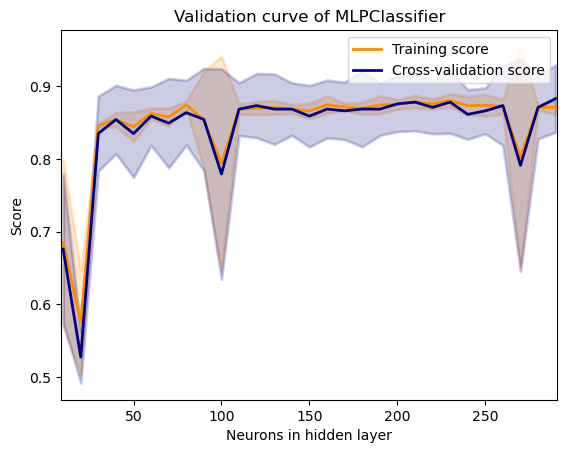

In [4]:
from sklearn.model_selection import validation_curve
import my_utils

param_range = np.arange(10,300,10)

train_score, test_score = validation_curve(MLPClassifier(random_state=0, activation='logistic'), X6, y, 
                                          param_name = 'hidden_layer_sizes', param_range = param_range, cv=5)

my_utils.plot_validation_curve(train_score, test_score, param_range, 'MLPClassifier', 'Neurons in hidden layer')

We see some unpredictable behavior at certain hidden layer sizes, where the training score goes haywire. There might be several reasons for this, 
1. Our training set only has ~400 datapoints, with 6 features in the above case, which may not be enough data points for neurons numbering above a certain threhsold. 
2. The learning rate might be affecting the performance but the default learning rate is small, so it is unlikely. 

This is the reason why validation curves are so necessary to plot before going to GridSearchCV. From now on, let us limit the number of neurons in the hidden layer to 50. 

### Next, let's add another hidden layer and see what happens

In [5]:
# Add another hidden layer
nn_clf = MLPClassifier(random_state=0, activation='logistic', hidden_layer_sizes=[50,50])

# 6 feature model
nn_clf.fit(X6_train, y6_train)

print("\nNumber of features: ", nn_clf.n_features_in_)
print("Number of layers: ", nn_clf.n_layers_)
print("Training accuracy for default single hidden layer NN with 6 features: ", nn_clf.score(X6_train, y6_train))
print("Test accuracy for default single hidden layer NN with 6 features: ", nn_clf.score(X6_test, y6_test))


Number of features:  6
Number of layers:  4
Training accuracy for default single hidden layer NN with 6 features:  0.8498498498498499
Test accuracy for default single hidden layer NN with 6 features:  0.7857142857142857


### Test accuracy increases from the single layer case. 

Plotting the validation curve is troublesome since the xlabels are 2 dimensional. So we shall just use the first element  

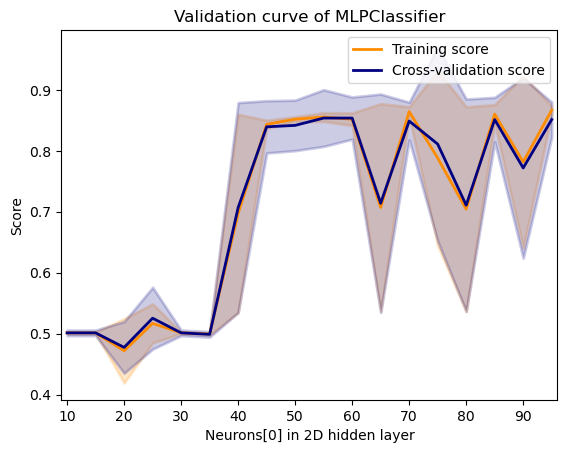

In [6]:
param_range = [[x,x] for x in np.arange(10,100,5)]
x_label = [elem[0] for elem in param_range]

train_score, test_score = validation_curve(MLPClassifier(random_state=0, activation='logistic'), X6, y, 
                                          param_name = 'hidden_layer_sizes', param_range = param_range, cv=5)

my_utils.plot_validation_curve(train_score, test_score, x_label, 'MLPClassifier', 'Neurons[0] in 2D hidden layer')

### Even more unpredictable behavior

Let us fix a few more parameters and observe its effects.

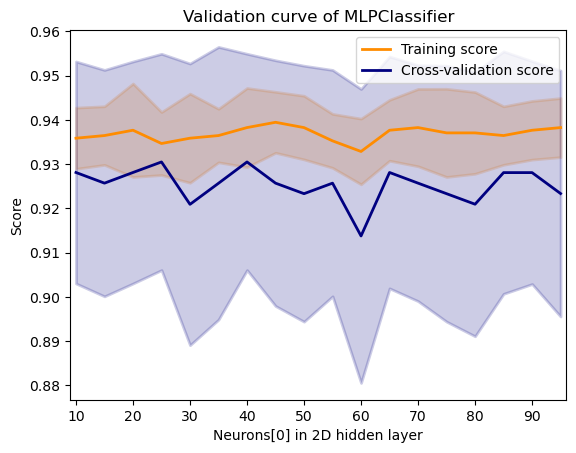

In [7]:
#Fix solver to adam, increase regularization, and introduce early stopping 

mlp_clf = MLPClassifier(random_state=0, activation='logistic', solver='lbfgs', alpha=0.0005) 
param_range = [[x,x] for x in np.arange(10,100,5)]
x_label = [elem[0] for elem in param_range]

train_score, test_score = validation_curve(mlp_clf, X6, y, 
                                          param_name = 'hidden_layer_sizes', param_range = param_range, cv=5)

my_utils.plot_validation_curve(train_score, test_score, x_label, 'MLPClassifier', 'Neurons[0] in 2D hidden layer')

### It seems like adam solver was not suitable for small datasets, but lbfgs improves the accuracy and removes the unpredictable behavior. Repeating the single hidden layer calculation with the same parameters. 

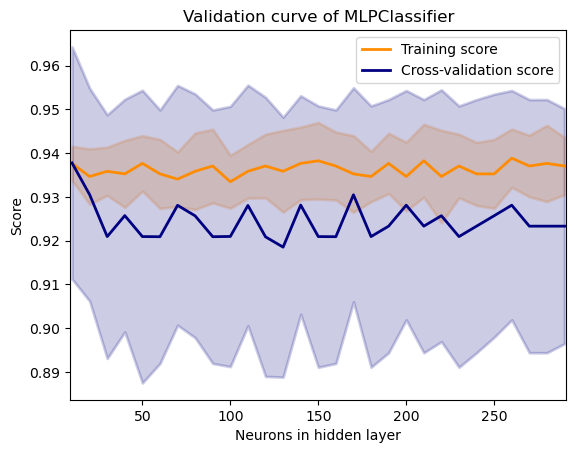

In [8]:
param_range = np.arange(10,300,10)

mlp_clf = MLPClassifier(random_state=0, activation='logistic', solver='lbfgs', alpha=0.0005)
train_score, test_score = validation_curve(mlp_clf, X6, y, 
                                          param_name = 'hidden_layer_sizes', param_range = param_range, cv=5)

my_utils.plot_validation_curve(train_score, test_score, param_range, 'MLPClassifier', 'Neurons in hidden layer')

Better performance here as well, even for less neurons in the hidden layer, which makes sense since the learning task is not complicated, so there is no reason to use very high number of neurons in the hidden layers. 

Using very high number of neurons will make the model learn noise instead of what our goal is and the fluctuations in the training score indicate that the model is indeed learning noise. 

Finally, let us see what happens when very small number of neurons are used in the network and we increase the alpha. 

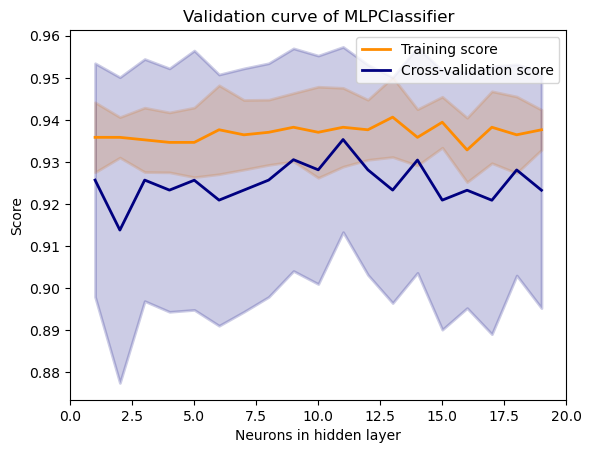

In [9]:
param_range = np.arange(1,20,1)

mlp_clf = MLPClassifier(random_state=0, activation='logistic', solver='lbfgs', alpha=0.005)
train_score, test_score = validation_curve(mlp_clf, X6, y, 
                                          param_name = 'hidden_layer_sizes', param_range = param_range, cv=5)

my_utils.plot_validation_curve(train_score, test_score, param_range, 'MLPClassifier', 'Neurons in hidden layer')

Still noisy but we have increased the value of alpha too, which should suppress overfitting and fluctuations. So the best fit for our system seems to be,
1. solver: lbfgs
2. hidden_layer_sizes = 50, either one or two hidden layers
3. alpha: 0.0005 (5 times the default)

## Loss curve
With the issues of learning, let us plot the loss curve for the model, which shows how the loss function behaves in each learning cycle (also called epochs). NOTE: Loss curves are only available for iterative solvers like adam or sgd


Number of features:  6
Number of layers:  4
Number of iterations run:  200
Training accuracy for default two hidden layer NN with 6 features:  0.8498498498498499
Test accuracy for default two hidden layer NN with 6 features:  0.7857142857142857


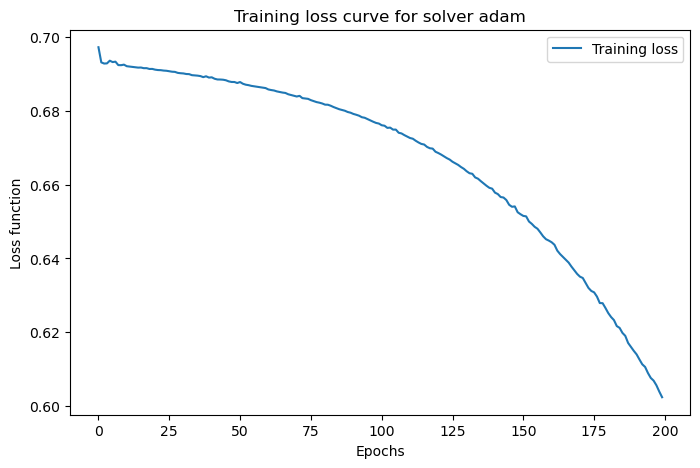

In [10]:
# Define the model
mlp_clf = MLPClassifier(solver='adam', activation='logistic', alpha = 0.0005, random_state=0, 
                        hidden_layer_sizes=[50,50]).fit(X6_train, y6_train)

# Print relevant info
print("\nNumber of features: ", mlp_clf.n_features_in_)
print("Number of layers: ", mlp_clf.n_layers_)
print("Number of iterations run: ", mlp_clf.n_iter_)
print("Training accuracy for default two hidden layer NN with 6 features: ", mlp_clf.score(X6_train, y6_train))
print("Test accuracy for default two hidden layer NN with 6 features: ", mlp_clf.score(X6_test, y6_test))

# Plot the loss function
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,5))

plt.plot(mlp_clf.loss_curve_, label='Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss function")
plt.title("Training loss curve for solver {}".format(mlp_clf.get_params(deep=True)['solver']))

plt.legend(loc="best")
plt.show()

A loss curve like this indicates the model is underfit and it needs more data or more iterations to run. We can increase the number of iteratios by using the max_iter parameter, but as we established before, solver like adam are not the best when we have lilmited number of data points. We could also improve the loss curve by decreasing the batch size, i.e., the size of the subsample of data taken for evaluation of loss function, but the instability still remains. 

We shall stick to lbfgs solver from now on.

### Repeating the calculations for H dataset

In [11]:
#Train test split
X3_train, X3_test, y3_train, y3_test = train_test_split(H3, y, test_size=0.20, random_state=0)
X6_train, X6_test, y6_train, y6_test = train_test_split(H6, y, test_size=0.20, random_state=0)

# Define the NN
mlp_clf = MLPClassifier(solver='lbfgs', activation='logistic', alpha = 0.0005, random_state=0, 
                        max_iter = 500, hidden_layer_sizes=[50,50])

# 3 feature model
mlp_clf.fit(X3_train, y3_train)

# Print relevant info
print("\nNumber of features: ", mlp_clf.n_features_in_)
print("Number of layers: ", mlp_clf.n_layers_)
print("Number of iterations run: ", mlp_clf.n_iter_)
print("Training accuracy for default two hidden layer NN with 3 features: ", mlp_clf.score(X3_train, y3_train))
print("Test accuracy for default two hidden layer NN with 3 features: ", mlp_clf.score(X3_test, y3_test))

# 6 feature model
mlp_clf.fit(X6_train, y6_train)

# Print relevant info
print("\nNumber of features: ", mlp_clf.n_features_in_)
print("Number of layers: ", mlp_clf.n_layers_)
print("Number of iterations run: ", mlp_clf.n_iter_)
print("Training accuracy for default two hidden layer NN with 6 features: ", mlp_clf.score(X6_train, y6_train))
print("Test accuracy for default two hidden layer NN with 6 features: ", mlp_clf.score(X6_test, y6_test))


Number of features:  3
Number of layers:  4
Number of iterations run:  500
Training accuracy for default two hidden layer NN with 3 features:  0.8948948948948949
Test accuracy for default two hidden layer NN with 3 features:  0.8214285714285714

Number of features:  6
Number of layers:  4
Number of iterations run:  500
Training accuracy for default two hidden layer NN with 6 features:  0.93993993993994
Test accuracy for default two hidden layer NN with 6 features:  0.9047619047619048
